# CONVOLUTIONAL NEURAL NETWORK

## Project- Write an algorithm for a Bone X-Ray detection

In [58]:
import pandas as pd
pd.set_option('display.max_colwidth', 99)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from numpy.random import seed
from tensorflow import set_random_seed
import random
random.seed(2048)
seed(2048)
set_random_seed(2048)
from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.regularizers import l2
from keras import backend as K
import gc

## Import Dataset
In the code cell below we import a csv file of training data and validation data 

- `train_image_paths.csv`
- `train_labeled_studies.csv`
- `valid_image_paths.csv`
- `valid_labeled_studies.csv`


In [59]:
# Loading dataset's CSVs
train_image_paths = pd.read_csv('MURA-v1.1/train_image_paths.csv', names=['filepath'])
train_labeled_studies = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', dtype={1: str}, names=['path','class'])
valid_image_paths = pd.read_csv('MURA-v1.1/valid_image_paths.csv', names=['filepath'])
valid_labeled_studies = pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', dtype={1: str}, names=['path','class'])


## Data Preprocessing

Manipulating the dataframes and merging validation data to the testing data 


In [60]:

# Manipulating the dataframes
train_image_paths['case'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[2])
train_image_paths['patient'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[3])
train_image_paths['patient_folder'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[4])
train_image_paths['patient_file'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[5])
train_image_paths['merge_path'] = train_image_paths['filepath'].apply(lambda x: x.rpartition('/')[0]+'/')

# Merging the training path images and labeled images in a training dataframe
train_data_df = train_image_paths.merge(train_labeled_studies, how='inner', left_on='merge_path', right_on='path').drop(columns=['merge_path', 'path'])

valid_image_paths['case'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[2])
valid_image_paths['patient'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[3])
valid_image_paths['patient_folder'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[4])
valid_image_paths['patient_file'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[5])
valid_image_paths['merge_path'] = valid_image_paths['filepath'].apply(lambda x: x.rpartition('/')[0]+'/')

# Merging the Validation path images and valid labeled images in a testing dataframe
test_data_df = valid_image_paths.merge(valid_labeled_studies, how='inner', left_on='merge_path', right_on='path').drop(columns=['merge_path', 'path'])

train_data_df.head(10)


,filepath,case,patient,patient_folder,patient_file,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,image1.png,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,image2.png,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,image3.png,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,image1.png,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,image2.png,1
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png,XR_SHOULDER,patient00002,study1_positive,image3.png,1
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image1.png,XR_SHOULDER,patient00003,study1_positive,image1.png,1
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image2.png,XR_SHOULDER,patient00003,study1_positive,image2.png,1
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image3.png,XR_SHOULDER,patient00003,study1_positive,image3.png,1
9,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image1.png,XR_SHOULDER,patient00004,study1_positive,image1.png,1


In [61]:
# XR_SHOULDER, XR_HUMERUS, XR_FINGER, XR_ELBOW, XR_WRIST, XR_FOREARM, XR_HAND
# xr_train_df = train_data_df[train_data_df.case=='XR_WRIST']
# xr_test_df = test_data_df[test_data_df.case=='XR_WRIST']
# Copy the training and testing dataframe into new variables

xr_train_df = train_data_df
xr_test_df = test_data_df


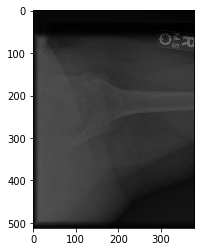

In [62]:
img = plt.imread('MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png')
plt.imshow(img)

## Shuffling of the training data

In [63]:
xr_train_df = xr_train_df.groupby(['class']).apply(lambda x: x.sample(10000,replace=True))

In [64]:
xr_train_df.shape


(20000, 6)

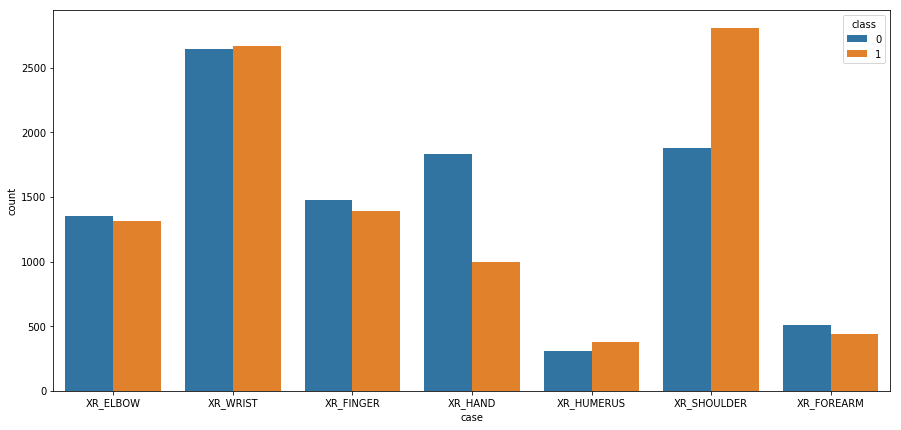

In [65]:
plt.figure(figsize=(15,7))
sns.countplot(data=xr_train_df,x='case',hue='class')

## Defining the functions for processing the images before producing the final dataset

In [68]:
pic_size = 256

# Function for making an image square, enhancing contrast and applying SHARPEN filter
def make_square(im, min_size = 256, fill_color =0):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('L', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    enhancer = ImageEnhance.Contrast(new_im)
    enhanced_im = enhancer.enhance(1.1)
    return enhanced_im.filter(ImageFilter.SHARPEN)

# invert an image
def invert_image(im):
    return ImageOps.invert(im)

def make_dataset(dataframe_var, test = False):
    train_x = []
    train_y = []
    patient_nr_y = []
    
    
    
    # Make each image square and of size 256x256
    for index, row in dataframe_var.iterrows():
        im = Image.open(row['filepath']).convert('L')
        squared = make_square(im)
        resized = squared.resize((pic_size, pic_size))
        
        # For the training set only, augment the data by applying random rotations and inversions (negative)
        
        if test == False: 
            rotated_r = resized.rotate(random.randint(10,30))
            rotated_r = invert_image(rotated_r)
            numpy_rotated_r_pic = np.array(rotated_r)/255
            train_x.append(numpy_rotated_r_pic)
            train_y.append(row['class'])
                
#             rotated_1 = resized.rotate(random.randint(330, 350))
        
            
        numpy_pic = np.array(resized)/255
        train_x.append(numpy_pic)
        train_y.append(row['class'])
        if test: patient_nr_y.append(row['patient'][7:]+'_'+row['patient_folder'])
            
    return train_x, train_y, patient_nr_y

                    
                
        



## Produce the final dataset

In [70]:
xr_train_x, xr_train_y, blank = make_dataset(xr_train_df)
xr_train_x = np.asarray(xr_train_x)
xr_train_y = np.asarray(xr_train_y)

xr_test_x, xr_test_y, xr_patient_y = make_dataset(xr_test_df, test = True)
xr_test_x = np.asarray(xr_test_x)
xr_test_y = np.asarray(xr_test_y)
xr_patient_y = np.asarray(xr_patient_y)

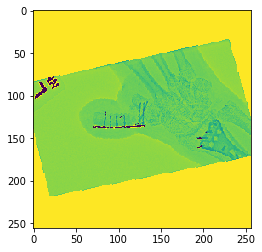

In [71]:
plt.imshow(xr_train_x[24332])


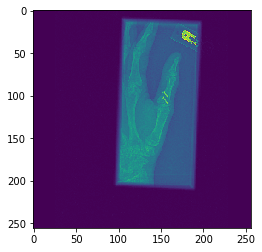

In [72]:
plt.imshow(xr_train_x[24331])

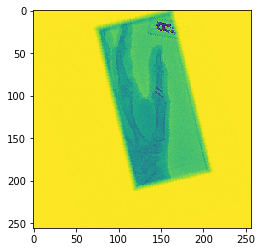

In [73]:
plt.imshow(xr_train_x[24330])

In [74]:
X_train = xr_train_x.reshape(np.shape(xr_train_x)[0],pic_size,pic_size,1)
y_train = xr_train_y
X_test = xr_test_x.reshape(np.shape(xr_test_x)[0],pic_size,pic_size,1)
y_test = xr_test_y

## Model definition & Evaluation

In [75]:
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [76]:
def train_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(pic_size, pic_size, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
    
    hs = model.fit(
        x=X_train,
        y=y_train,
        validation_split=0.1,
        epochs=50,
        verbose=1,
        shuffle=True,
        batch_size=64,
        callbacks=[es]
    )
    
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

In [77]:
mura_model, mura_hs = train_model()
mura_eval = mura_model.evaluate(X_test, y_test, verbose=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/50
36000/36000 [==============================] - 6157s 171ms/step - loss: 0.6906 - binary_accuracy: 0.5479 - val_loss: 0.7842 - val_binary_accuracy: 0.0000e+00
Epoch 2/50
36000/36000 [==============================] - 3514s 98ms/step - loss: 0.6869 - binary_accuracy: 0.5565 - val_loss: 0.8369 - val_binary_accuracy: 0.1115
Epoch 3/50
36000/36000 [==============================] - 30044s 835ms/step - loss: 0.6839 - binary_accuracy: 0.5601 - val_loss: 0.7946 - val_binary_accuracy: 0.1400
Epoch 4/50
36000/36000 [==============================] - 8944s 248ms/step - loss: 0.6723 - binary_accuracy: 0.5797 - val_loss: 0.7529 - val_binary_accuracy: 0.2020
Epoch 5/50
36000/36000 [==============================] - 6850s 190ms/step - loss: 0.6550 - binary_accuracy: 0.6052 - val_loss: 0.7552 - val_binary_accuracy: 0.2995
Epoch 6/50
36000/36000 [==============================] - 3946s 110ms/step - loss: 0.6277 - binary_accuracy: 0.6360 - val_

Train Loss     : 0.29156
Validation Loss: 0.88601
Test Loss      : 1.05730
---
Train Accuracy     : 0.87178
Validation Accuracy: 0.61800
Test Accuracy      : 0.61151


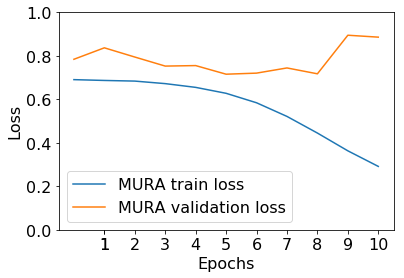

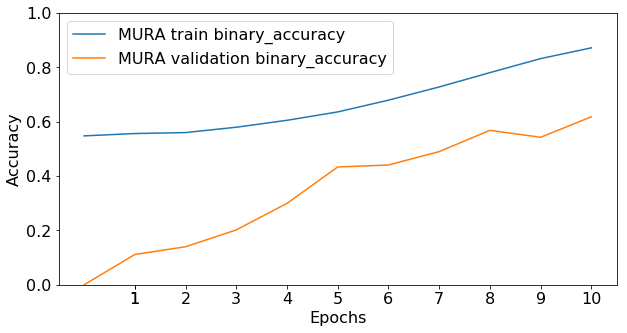

In [78]:
print("Train Loss     : {0:.5f}".format(mura_hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mura_hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mura_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mura_hs.history['binary_accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mura_hs.history['val_binary_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mura_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'MURA': mura_hs}, epochs=10, metric='loss')
plot_history(hs={'MURA': mura_hs}, epochs=10, metric='binary_accuracy')

In [82]:
predictions = mura_model.predict(X_test)

## Classification Reports and Kappa Measure


#### Get all the indices separated by study from the test set

In [83]:
study_indices = []
tmp_list = []
for idx, study in enumerate(xr_patient_y):
    if idx == 0: previous_study = study
    if study != previous_study:
        study_indices.append(tmp_list)
        tmp_list = []
    tmp_list.append(idx)
    previous_study = study

#### Define the voting functions to be used for classifying each study

In [84]:
# Here the votes are simply rounded
def get_vote_round(lst):
    return round(sum([round(x) for x in np.ravel(lst)]) / len(lst))

# Here if there exists a vote of certainty over a threshold, it will be dominant. Otherwise, votes are simply rounded
def get_vote_roundmax(lst):
    threshold = 0.85
    if max(np.ravel(lst)) >= threshold:
        return 1
    else:
        return get_vote_round(lst)
    
# Here the true list is shrunk, so that there is only one element for each study   
def concat_true_lst(lst):
    return round(sum([round(x) for x in lst]) / len(lst))

# This produces 3 lists given the above functions
def voting_list(true_lst, pred_lst, indices):
    new_true_list = []
    new_pred_list_round = []
    new_pred_list_roundmax = []
    for outer_idx in indices:
        new_true_list.append(concat_true_lst(list(map(int, true_lst[outer_idx]))))
        new_pred_list_round.append(get_vote_round(list(pred_lst[outer_idx])))
        new_pred_list_roundmax.append(get_vote_roundmax(list(pred_lst[outer_idx])))
    return new_true_list, new_pred_list_round, new_pred_list_roundmax

In [85]:
true_lst, pred_lst_round, pred_lst_roundmax = voting_list(xr_test_y, predictions, study_indices)

#### Simple round voting scheme

In [86]:
print(classification_report(true_lst, pred_lst_round, target_names=['negative (0)','positive (1)']))

              precision    recall  f1-score   support

negative (0)       0.63      0.83      0.72       660
positive (1)       0.66      0.41      0.51       538

 avg / total       0.65      0.64      0.62      1198



In [87]:
confusion_matrix(true_lst, pred_lst_round)

array([[546, 114],
       [315, 223]])

In [92]:
print('Kappa score: ' + str(cohen_kappa_score(true_lst, pred_lst_round)))

Kappa score: 0.25041785898681224


#### Voting scheme with certainty threshold

In [88]:
print(classification_report(true_lst, pred_lst_roundmax, target_names=['negative (0)','positive (1)']))

              precision    recall  f1-score   support

negative (0)       0.66      0.71      0.68       660
positive (1)       0.61      0.55      0.58       538

 avg / total       0.64      0.64      0.64      1198



In [89]:
confusion_matrix(true_lst, pred_lst_roundmax)

array([[467, 193],
       [240, 298]])

In [90]:
print('Kappa score: ' + str(cohen_kappa_score(true_lst, pred_lst_roundmax)))

Kappa score: 0.26360753294171424
